In [1]:
from kitti_detection import config
from kitti_detection.dataset import DataSample, class_names, load_train_val_test_dataset
from kitti_detection.utils import display_samples_h

import torch
from torch import nn, optim, Tensor
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.tv_tensors import BoundingBoxes
from torchvision.ops.roi_pool import RoIPool
from torchvision.models import vgg16, VGG16_Weights
from torchvision.ops import box_iou

import cv2
import numpy as np

from typing import Optional


In [2]:
transforms = v2.Compose([
    v2.RandomCrop(size=(370, 370)),
    v2.SanitizeBoundingBoxes(),    
])

In [3]:
train_dataset, val_dataset, test_dataset = load_train_val_test_dataset()

train_dataset.transform = transforms

./data_object_image_2/training/image_2/


In [4]:
n_classes = len(class_names)

<class 'list'>
<class 'torch.Tensor'>
tensor([[[ 22,  25,  19,  ..., 255, 255, 255],
         [ 22,  25,  19,  ..., 255, 255, 255],
         [ 21,  26,  24,  ..., 255, 255, 255],
         ...,
         [120, 123, 108,  ..., 114, 116, 123],
         [114, 113, 114,  ...,  99,  94, 120],
         [ 96,  98, 117,  ..., 112, 110, 130]],

        [[ 24,  25,  24,  ..., 255, 255, 255],
         [ 26,  27,  25,  ..., 255, 255, 255],
         [ 24,  29,  28,  ..., 255, 255, 255],
         ...,
         [108, 116, 113,  ..., 130, 123, 122],
         [122, 129, 113,  ..., 113, 104, 122],
         [118, 127, 115,  ..., 110, 107, 124]],

        [[ 17,  23,  24,  ..., 255, 255, 255],
         [ 24,  25,  26,  ..., 255, 255, 255],
         [ 25,  26,  26,  ..., 255, 255, 255],
         ...,
         [104, 118, 117,  ..., 133, 153, 138],
         [126, 104, 106,  ..., 132, 121, 125],
         [115, 125, 124,  ..., 131, 118, 122]]], dtype=torch.uint8)
<class 'dict'>
{'labels': tensor([0], dtype=torch

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


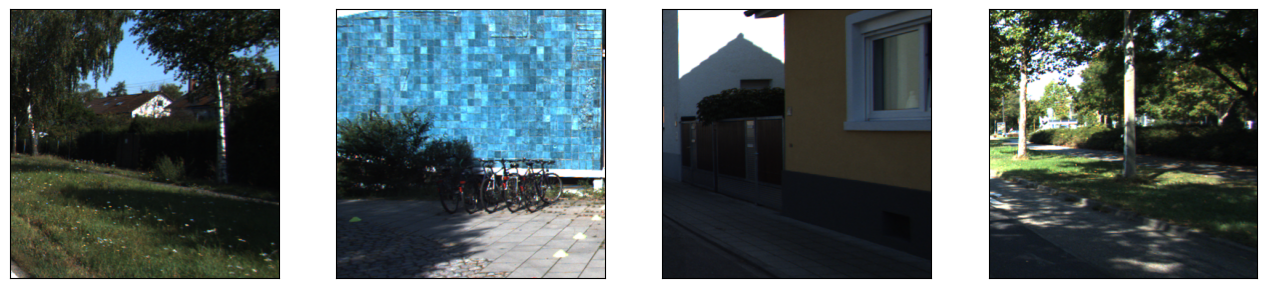

In [5]:
data_loader = DataLoader(train_dataset, batch_size=None, shuffle=True)
elements = next(iter(data_loader))
print(type(elements))
for element in elements:
    print(type(element))
    print(element)
display_samples_h([next(iter(data_loader)) for _ in range(4)])

**VGG16**
<br>
<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*0M8CobXpNwFDCmOQ">

In [6]:
class FastRCNN(nn.Module):
    
    def __init__(self) -> None:
        super().__init__()
        self.dropout=0.5
                
        self.conv = self._prepare_vgg16(weights=None)
        self.roi_pool = RoIPool(output_size=(7, 7), spatial_scale=0.0625) # Input: 224 * 224 | roi input: 14 * 14 -> 14/224 = 0.0625
        self.fc = nn.Sequential(
            nn.Linear(in_features=512 * 7 * 7, out_features=4096),   # Is it 512? Not 64?
            nn.ReLU(True),
            nn.Dropout(p=self.dropout),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(p=self.dropout),
            nn.Linear(in_features=4096, out_features=4096),
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Linear(in_features=4096, out_features=n_classes + 1),
        )
        self.bbox_regressor = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Linear(in_features=4096, out_features=4),
        )

    def forward(self, x):
        # Model input: tuple of 1. single image tensor 2. BoundingBoxes tensor of region proposal ROIs
        
        assert isinstance(x, tuple[Tensor, BoundingBoxes])

        img, rois = x

        fmap = self.conv(img)
        windows = self.roi_pool(fmap, boxes=rois)
        windows = torch.flatten(windows, start_dim=1)
        windows = self.fc(windows)
        pred_classes = self.classifier(windows)
        pred_bboxes = self.bbox_regressor(windows)
        
        return pred_classes, pred_bboxes
    
    def _prepare_vgg16(weights: Optional[VGG16_Weights] = None) -> nn.Module:
        vgg16 = vgg16(weights)
        vgg16.features = nn.Sequential(*list(vgg16.features.children())[:-1]) # Removing tha last Max Pooling layer of VGG
        vgg16.classifier = None # Remove the classifier entirely
        return vgg16




In [7]:
# See 2.1 / Multi task loss

class MultiTaskLoss(nn.Module):

    def __init__(self, classification_weights = None, lmbd=1.0) -> None:
        self.classification_weights = classification_weights
        self.lmbd = lmbd
        pass

    def forward(self, input: torch.Tensor, target: torch.Tensor):
        input_class, input_bbox = input
        target_class, target_bbox = target
        cls_loss = nn.functional.cross_entropy(input_class, target_class)

        c = None # [u > 1] factor (tensor)
        loc_loss = None # TODO use nn.SoftL1Loss and sum()

        return cls_loss + self.lmbd * c * loc_loss

In [8]:
TRAIN_ROI_PROPOSALS = 64
BIG_IOU_THRESHOLD = 0.25

In [9]:
def convert_tensor_to_cv2(tensor: Tensor) -> np.array:
    # Is the tensor on the GPU???
    numpy_image = tensor.numpy() # force=True if on GPU

    # CHW -> HWC
    cv2_image = np.transpose(numpy_image, (1, 2, 0))
    
    # Convert color space: RGB -> BGR
    cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_RGB2BGR)

    return cv2_image


In [10]:
def generate_roi_proposals(img) -> BoundingBoxes:
    # Convert image from tensor to opencv format.
    cv2_image = convert_tensor_to_cv2(img)

    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(cv2_image)
    ss.switchToSelectiveSearchQuality() #Other option is fast, but less accurate
    rects = ss.process() # rects is a np array containing [x, y, w, h] numpy arrays

    boxes = [(float(rect[0]), float(rect[1]), float(rect[0]+rect[2]), float(rect[1]+rect[3]))  for rect in rects] # convert to the consistent XYXY format

    return BoundingBoxes(boxes, format='XYXY', canvas_size=v2.functional.get_size(img))

In [11]:
def getBigIouProposals(ious: torch.Tensor, roi_proposals: torch.Tensor) -> torch.Tensor:
    # Max number of proposals to select
    max_n_proposals = int(TRAIN_ROI_PROPOSALS * BIG_IOU_THRESHOLD)

    max_ious = ious.max(dim=1)[0]
    # Sort only those proposals, where the max IoU is greater than the threshold
    valid_proposals = roi_proposals[max_ious >= 0.5]
    valid_ious = max_ious[max_ious >= 0.5]

    # Sort the valid proposals by IoU in descending order
    sorted_indices = torch.argsort(valid_ious, descending=True)
    sorted_proposals = valid_proposals[sorted_indices]
    sorted_ious = valid_ious[sorted_indices]

    top_proposals = sorted_proposals[:max_n_proposals] # Tensor of tensors
    top_ious = sorted_ious[:max_n_proposals]
    
    return top_proposals


def getSmallIouProposals(ious: torch.Tensor, roi_proposals: torch.Tensor, big_iou_proposals: int) -> torch.Tensor:
    max_n_proposals = TRAIN_ROI_PROPOSALS - big_iou_proposals

    max_ious = ious.max(dim=1)[0]
    # Sort only those proposals, where the max IoU is greater than the threshold
    valid_proposals = roi_proposals[(max_ious < 0.5) & (max_ious >= 0.1)]
    valid_ious = max_ious[(max_ious < 0.5) & (max_ious >= 0.1)]

    # Sort the valid proposals by IoU in descending order
    sorted_indices = torch.argsort(valid_ious, descending=True)
    sorted_proposals = valid_proposals[sorted_indices]
    sorted_ious = valid_ious[sorted_indices]

    top_proposals = sorted_proposals[:max_n_proposals] # Tensor of tensors
    top_ious = sorted_ious[:max_n_proposals]
    
    return top_proposals


In [12]:
def generate_training_samples(ground_truth: DataSample) -> tuple[BoundingBoxes, Tensor, Tensor]:
    # input: DataSample containing image and ground truth labels
    # output: tuple of 1. ROI proposals 2. target classes 3. target bounding box corrections
    #         each are tensors of shape (TRAINING_ROI_PROPOSALS, ...)

    # DataSample -> tuple[torch.Tensor, dict[str, torch.Tensor]]
    img = ground_truth[0]
    roi_proposals = generate_roi_proposals(img)
    #print(f'Type: {type(roi_proposals[0])}')
    #print(roi_proposals[0])

    # If the image does not have any Ground thruth bounding boxes
    if not ground_truth[1].get('boxes').shape[0]:
        return None, None, None

    # Get the iou of proposals with every ground thruth -> n_proposals * n_gt
    ious = box_iou(roi_proposals, ground_truth[1].get('boxes'))
    
    big_iou_proposals = getBigIouProposals(ious, roi_proposals)
    small_iou_proposals = getSmallIouProposals(ious, roi_proposals, big_iou_proposals.shape[0])
    print(big_iou_proposals.shape[0])
    print(f'big: {big_iou_proposals.shape}')
    print(f'small: {small_iou_proposals.shape}')


    
    test_dict_big = {}
    test_dict_big['labels'] = torch.zeros(16, dtype=int)
    test_dict_big['boxes'] = BoundingBoxes(big_iou_proposals, format='XYXY', canvas_size=v2.functional.get_size(img))

    test_dict_small = {}
    test_dict_small['labels'] = torch.zeros(48, dtype=int)
    test_dict_small['boxes'] = BoundingBoxes(small_iou_proposals, format='XYXY', canvas_size=v2.functional.get_size(img))

    display_samples_h([[img, test_dict_big]])
    display_samples_h([[img, test_dict_small]])

    return None, None, None

16
big: torch.Size([16, 4])
small: torch.Size([48, 4])


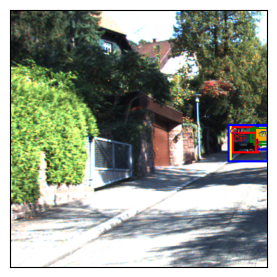

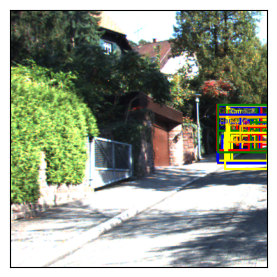

(None, None, None)

In [13]:
test_data_sample = next(iter(data_loader))
generate_training_samples(test_data_sample)

In [42]:
box1 = torch.tensor([[10, 20, 110, 220]], dtype=torch.float)  # Single box in a batch
box2 = torch.tensor([[15, 25, 165, 275]], dtype=torch.float)  # Single box in a batch
print(f'The IoU is {box_iou(box1, box2)}')  #



The IoU is tensor([[0.4753]])


In [11]:
def train_model(model: nn.Module,
                device: str,
                train_loader: DataLoader,
                valid_loader: DataLoader,
                batch_size: int,
                loss_fn: nn.Module,
                optimizer: optim.Optimizer,
                epochs: int):
    num_samples = len(train_loader.dataset)
    num_batches = len(train_loader)

    for epoch in range(epochs):
        
        # train
        model = model.train()
        train_loss = 0.0
        for idx, sample in enumerate(train_loader):
            img = sample[0]
            roi, target_class, target_bbox_corr = generate_training_samples(sample)

            X = (img, roi)
            Y = (target_class, target_bbox_corr)
            pred = model(X)
            
            loss = loss_fn(pred, Y)

            # Backpropagation
            loss.backward() # TODO backprop after two images?
            optimizer.step()
            optimizer.zero_grad()

            loss = loss.item()
            train_loss += loss
            print(f'[{epoch + 1:>2}/{epochs}]: train_loss={loss:>5f}  [{idx:>5d}/{num_samples:>5d}]', end='\r')
            
        train_loss /= num_batches

        # validate
        # TODO

        print(f'[{epoch + 1:>2}/{epochs}]: {train_loss=:5f} {val_loss=:5.5f} {val_accuracy=:2.1%}')